In [1]:
import requests
import gpxpy
import polyline
import pyproj

import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
def get_gpx_df(gpx_file):
    with open(gpx_file, 'r') as file:
        gpx = gpxpy.parse(file)

    data = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                })

    df = pd.DataFrame(data)

    df['prev_latitude'] = df['latitude'].shift(1)
    df['prev_longitude'] = df['longitude'].shift(1)
    
    g = pyproj.Geod(ellps='WGS84')
    
    df['fwd_azimuth'] = df.apply(
        lambda x: g.inv(x['prev_longitude'], x['prev_latitude'], x['longitude'], x['latitude'])[0] if not pd.isna(x['prev_latitude']) and not pd.isna(x['prev_longitude']) else 0, 
        axis=1,
    )
    df['fwd_azimuth'] = df['fwd_azimuth'].apply(lambda x: x + 360 if x < 0 else x)
    
    df['fwd_azimuth_delta'] = df['fwd_azimuth'].diff()
    
    df = df.drop(columns=[
        'prev_latitude', 
        'prev_longitude',
        'fwd_azimuth'
    ])
    
    return df

In [3]:
def get_route(points):
    params = {
        'geometries': 'polyline6',
    }
    response = requests.get(f"http://127.0.0.1:6000/route/v1/foot/{points}", params=params)
    response.raise_for_status()
    routes = response.json()
    return polyline.decode(routes['routes'][0]['geometry'], 6)

In [4]:
def get_nearest(coords):
    lat, lon = coords
    response = requests.get(f"http://127.0.0.1:6000/nearest/v1/foot/{lon},{lat}")
    response.raise_for_status()
    waypoints = response.json()
    location = waypoints['waypoints'][0]['location']
    return f"{location[0]},{location[1]}"

In [24]:
def get_original(coords):
    lat, lon = coords
    return f"{lon},{lat}"

In [5]:
def plot_gpx(df):
    plt.figure(figsize=(10, 10))
    plt.plot(df['longitude'], df['latitude'], color='red', label='Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

In [6]:
df = get_gpx_df('../data/garmin.gpx')
df.head()

,latitude,longitude,fwd_azimuth_delta
0,1.309403,103.896450,NaN
1,1.309681,103.896458,1.722692
2,1.309693,103.896455,345.022490
3,1.309507,103.896450,-165.211584
4,1.309467,103.896446,4.545150


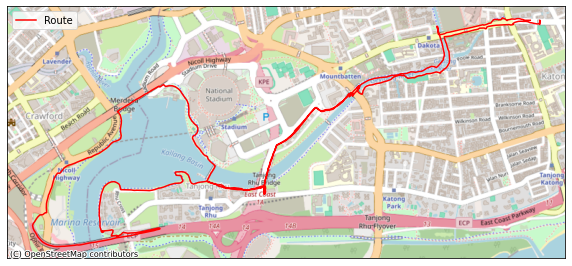

In [7]:
plot_gpx(df)

In [55]:
df.shape

(1047, 3)

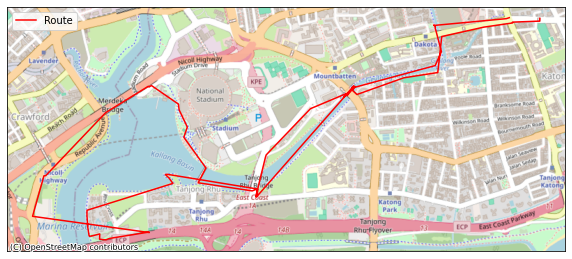

In [19]:
turns_df = df[abs(df['fwd_azimuth_delta']) >= 45]
plot_gpx(turns_df)

In [20]:
turns_df.shape

(85, 3)

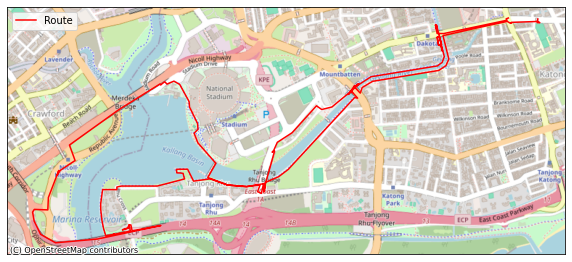

In [26]:
points = list(turns_df[['latitude', 'longitude']].to_records(index=False))

route_points = ';'.join(map(get_original, points))
# route_points = ';'.join(map(get_nearest, points))

route = get_route(route_points)
osrm_df = pd.DataFrame(route, columns=['latitude', 'longitude'])

plot_gpx(osrm_df)